# Preparation and Overview


Team:
* Travis Peck (Graduate)
* Quinn Matthews (Undergraduate)
* Chris Hirschbrich (Undergraduate)
* Tyler Olbright (Undergraduate)

## Buisness Use Case

TODO: Explain the task and what business-case or use-case it is designed to solve (or designed to investigate). Detail exactly what the classification task is and what parties would be interested in the results. For example, would the model be deployed or used mostly for offline analysis? As in previous labs, also detail how good the classifier needs to perform in order to be useful. 


## Data Preprocessing

In [515]:
# import libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('austinHousingData.csv')

#
# Update columns
#

# Drop columns that are not useful for the analysis
data = data.drop(['zpid',
                  'streetAddress',
                  'description',
                  'homeImage',
                  'numOfPhotos',
                  'latestPriceSource',
                  'numPriceChanges',
                  'zipcode',
                  'latitude',
                  'longitude',
                  ], axis=1)

# Remove extreme outliers
third_quartile = data['latestPrice'].quantile(0.75)
first_quartile = data['latestPrice'].quantile(0.25)
IQR = third_quartile - first_quartile

initial_count = data.shape[0]
data = data[data['latestPrice'] < (third_quartile + 3 * IQR)]
data = data[data['latestPrice'] > (first_quartile - 3 * IQR)]
print("Number of outliers removed: ", initial_count - data.shape[0])

# Set the latestPrice to a categorical variable
data['latestPrice'] = pd.cut(data['latestPrice'], 
                             bins=[0, 
                                   data['latestPrice'].quantile(0.33), 
                                   data['latestPrice'].quantile(0.66), 
                                   data['latestPrice'].max()], 
                             labels=['Low', 'Medium', 'High'])
data['latestPrice'] = pd.Categorical(data['latestPrice'], categories=['Low', 'Medium', 'High'], ordered=True)

# Combine the numOfSchools into one column
data['numOfSchools'] = data['numOfPrimarySchools'] + data['numOfElementarySchools'] + data['numOfMiddleSchools'] + data['numOfHighSchools']
data = data.drop(['numOfPrimarySchools', 'numOfElementarySchools', 'numOfMiddleSchools', 'numOfHighSchools'], axis=1)

# Conver true/false to 1/0
for col in data.columns:
    if data[col].dtype == 'bool':
        data[col] = data[col].astype(int)


#
# Display Data information
#

# Print the first 5 rows of the dataframe.
data.head()


Number of outliers removed:  513


,city,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,homeType,...,lotSizeSqFt,livingAreaSqFt,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,numOfSchools
0,pflugerville,1.98,2,1,1,1,1,0,0,Single Family,...,6011.0,2601.0,1.266667,2.666667,1063,14,3.0,4,2,3
1,pflugerville,1.98,2,1,1,1,1,0,0,Single Family,...,6185.0,1768.0,1.400000,2.666667,1063,14,2.0,4,1,3
2,pflugerville,1.98,0,1,1,0,1,0,0,Single Family,...,7840.0,1478.0,1.200000,3.000000,1108,14,2.0,3,1,4
3,pflugerville,1.98,2,1,1,1,1,0,0,Single Family,...,6098.0,1678.0,1.400000,2.666667,1063,14,2.0,3,1,3
4,pflugerville,1.98,0,1,1,0,1,0,0,Single Family,...,6708.0,2132.0,1.133333,4.000000,1223,14,3.0,3,2,3


TODO: Add a description of the data preprocessing steps and explain decisions made

## Data Quality

In [516]:
# TODO: Copy similar code from Lab 1 to display: data types/description, missing values, duplicate rows, etc.

In [517]:
# Variable Breakdown
data.describe() # TODO: We could probably make this more relevant to the data by only showing the relevant columns (i.e. not the ID columns, binary columns should be shown as counts, etc.)

,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,parkingSpaces,yearBuilt,...,lotSizeSqFt,livingAreaSqFt,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,numOfSchools
count,14658.000000,14658.000000,14658.000000,14658.000000,14658.000000,14658.000000,14658.000000,14658.000000,14658.000000,14658.000000,...,1.465800e+04,14658.000000,14658.000000,14658.000000,14658.000000,14658.000000,14658.000000,14658.000000,14658.000000,14658.000000
mean,1.994561,1.201392,0.529745,0.981785,0.546255,0.990108,0.071838,0.221108,1.196753,1988.247101,...,1.868174e+04,2122.987447,1.824960,5.740649,1234.836062,14.836540,2.605025,3.407150,1.453882,3.005594
std,0.053957,1.318840,0.499131,0.133734,0.497873,0.098970,0.258228,0.415007,1.319437,21.428899,...,3.820848e+05,1273.719655,1.046277,1.862691,329.232708,1.755436,0.940756,0.826083,0.518033,0.334456
min,1.980000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1906.000000,...,1.000000e+02,300.000000,0.200000,2.333333,396.000000,10.000000,0.000000,0.000000,1.000000,0.000000
25%,1.980000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1974.000000,...,6.490000e+03,1464.000000,1.100000,4.000000,966.000000,14.000000,2.000000,3.000000,1.000000,3.000000
50%,1.980000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1992.000000,...,8.145000e+03,1937.000000,1.566667,5.666667,1277.000000,15.000000,3.000000,3.000000,1.000000,3.000000
75%,1.980000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000,2006.000000,...,1.067200e+04,2594.000000,2.266667,7.000000,1496.000000,16.000000,3.000000,4.000000,2.000000,3.000000
max,2.210000,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,22.000000,2020.000000,...,3.415452e+07,109292.000000,9.000000,9.500000,1913.000000,19.000000,27.000000,20.000000,4.000000,5.000000


TODO: Determine if we need to do any further discussion of the data descriptions here.

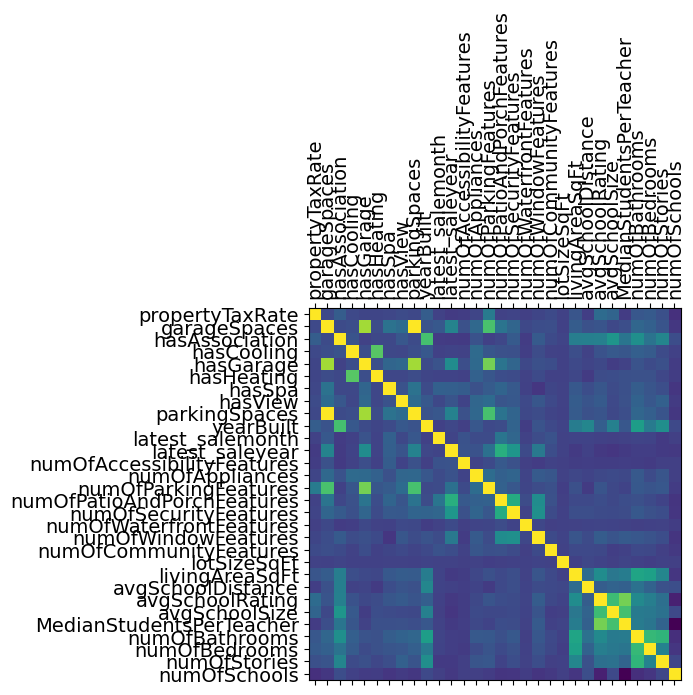

In [518]:
# Correlation Heatmap
num_data = data.select_dtypes(include=[np.number])
plt.matshow(num_data.corr())
plt.xticks(range(num_data.shape[1]), num_data.columns, fontsize=14, rotation=90)
plt.yticks(range(num_data.shape[1]), num_data.columns, fontsize=14)
plt.show()


In [519]:
# List column pairs with the highest correlation
correlation_matrix = num_data.corr().abs()
correlation_pairs = correlation_matrix.unstack()
correlation_pairs = correlation_pairs.sort_values(ascending=False)
correlation_pairs = correlation_pairs[correlation_pairs > 0.5]
correlation_pairs = correlation_pairs[correlation_pairs < 1]
correlation_pairs = correlation_pairs.drop_duplicates()
correlation_pairs.head(15)

parkingSpaces          garageSpaces                  0.997262
garageSpaces           hasGarage                     0.830263
parkingSpaces          hasGarage                     0.826683
avgSchoolRating        MedianStudentsPerTeacher      0.742077
hasGarage              numOfParkingFeatures          0.738863
hasHeating             hasCooling                    0.677127
numOfParkingFeatures   garageSpaces                  0.644840
                       parkingSpaces                 0.641291
yearBuilt              hasAssociation                0.636002
avgSchoolSize          MedianStudentsPerTeacher      0.635497
avgSchoolRating        avgSchoolSize                 0.612603
numOfBedrooms          numOfBathrooms                0.589124
numOfStories           numOfBathrooms                0.569478
latest_saleyear        numOfPatioAndPorchFeatures    0.540758
numOfSecurityFeatures  numOfPatioAndPorchFeatures    0.521865
dtype: float64

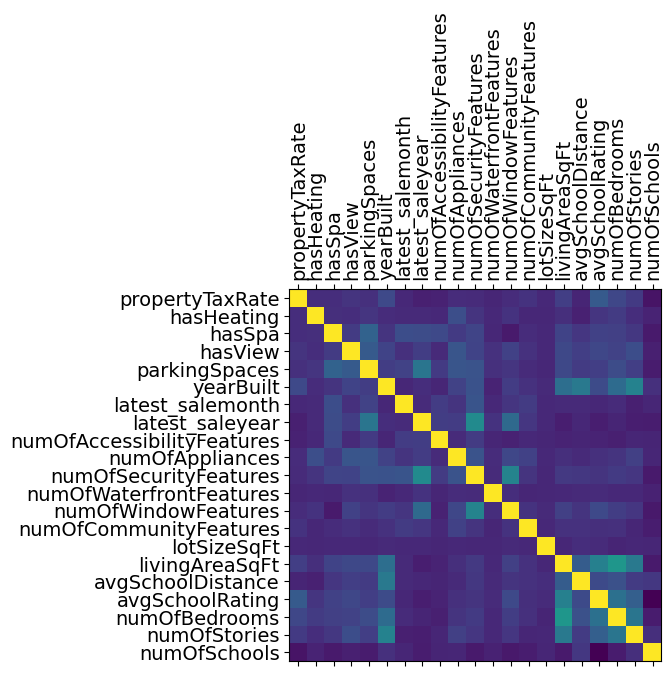

In [520]:
# Drop related columns with high correlation
data = data.drop(['garageSpaces',
                  'hasGarage',
                  'MedianStudentsPerTeacher',
                  'avgSchoolSize',
                  'numOfBathrooms',
                  'numOfParkingFeatures',
                  'hasCooling',
                  'hasAssociation',
                  'numOfPatioAndPorchFeatures'
                  ], axis=1)

# Show new heatmap
num_data = data.select_dtypes(include=[np.number])
plt.matshow(num_data.corr())
plt.xticks(range(num_data.shape[1]), num_data.columns, fontsize=14, rotation=90)
plt.yticks(range(num_data.shape[1]), num_data.columns, fontsize=14)
plt.show()


## Data Splitting

In [521]:
from sklearn.model_selection import train_test_split

# Split the data into a training and test set.
train, test = train_test_split(data, test_size=0.2, random_state=33)

print("Training set size: ", train.shape[0])
print("Test set size: ", test.shape[0])

Training set size:  11726
Test set size:  2932


TODO: Argue "for" or "against" splitting your data using an 80/20 split. That is, why is the 80/20 split appropriate (or not) for your dataset?

# Modeling (5 points total)

## Classifier

* [2 points] Create a custom, one-versus-all logistic regression classifier using numpy and scipy to optimize. Use object oriented conventions identical to scikit-learn. You should start with the template developed by the instructor in the course. You should add the following functionality to the logistic regression classifier:
  *  TODO: Ability to choose optimization technique when class is instantiated: either steepest ascent, stochastic gradient ascent, and Newton's method. It is recommended to call this the "solver" input for the class.
  * TODO: Update the gradient calculation to include a customizable regularization term (either using no regularization, L1 regularization, L2 regularization, or both L1 and L2 regularization). Associate a cost with the regularization term, "C", that can be adjusted when the class is instantiated.  


In [522]:
import numpy as np
class BinaryLogisticRegressionBase:
    # private:
    def __init__(self, eta, solver, iterations=20):
        self.eta = eta
        self.solver = solver
        self.iters = iterations
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        return 'Base Binary Logistic Regression Object, Not Trainable'
    
    # convenience, private and static:
    @staticmethod
    def _sigmoid(theta):
        return 1/(1+np.exp(-theta)) 
    
    @staticmethod
    def _add_intercept(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    # public:
    def predict_proba(self, X, add_intercept=True):
        # add bias term if requested
        Xb = self._add_intercept(X) if add_intercept else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    

In [523]:
# inherit from base class
class BinaryLogisticRegression(BinaryLogisticRegressionBase):
    #private:
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    def _get_gradient(self,X,y):
        # programming \sum_i (yi-g(xi))xi
        gradient = np.zeros(self.w_.shape) # set gradient to zero
        for (xi,yi) in zip(X,y):
            # the actual update inside of sum
            gradi = (yi - self.predict_proba(xi,add_intercept=False))*xi 
            # reshape to be column vector and add to gradient
            gradient += gradi.reshape(self.w_.shape) 
        
        return gradient/float(len(y))
       
    # public:
    def fit(self, X, y):
        Xb = self._add_intercept(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 


In [524]:
# now lets do some vectorized coding
import numpy as np
from scipy.special import expit

class VectorBinaryLogisticRegression(BinaryLogisticRegression):
    # inherit from our previous class to get same functionality
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # but overwrite the gradient calculation
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_intercept=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        return gradient.reshape(self.w_.shape)


In [525]:
class LogisticRegression:
    def __init__(self, eta, iterations=20, solver='SteepestAscent'): #TODO: We need to do something with solver
        self.eta = eta
        self.iters = iterations
        self.solver = solver
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = (y==yval) # create a binary problem
            # train the binary classifier for this class
            blr = VectorBinaryLogisticRegression(self.eta,
                                                 self.solver,
                                                 self.iters)
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier

        return np.hstack(probs) # make into single matrix

    def predict(self,X):
        return self.unique_[np.argmax(self.predict_proba(X),axis=1)] # take argmax along row

## Training


* [1.5 points] Train your classifier to achieve good generalization performance. That is, adjust the optimization technique and the value of the regularization term(s) "C" to achieve the best performance on your test set.
  * TODO: Visualize the performance of the classifier versus the parameters you investigated.
  * TODO: Is your method of selecting parameters justified? That is, do you think there is any "data snooping" involved with this method of selecting parameters?


In [526]:
lr = LogisticRegression(0.2,1500)
X = train.select_dtypes(include=[np.number])
y = train['latestPrice']
lr.fit(X.values,y.values)
print(lr)

MultiClass Logistic Regression Object with coefficients:
[[-1.39722367e+00 -3.78415578e+00 -1.23748462e+00  3.24928399e+00
   3.51749490e+00  1.12556733e+01 -3.31962960e+03  5.00779851e+00
  -2.81231014e+03  8.02106430e-01 -3.63176462e+00  2.88647329e+00
   8.91437830e-02  2.24062651e+00 -3.32201944e-01 -1.30926324e+03
   6.00146521e+03 -1.01208753e+01  3.85883592e+01 -7.34372272e+00
  -3.95076625e+00 -7.51227419e+00]
 [ 1.08815384e+00  2.55758409e+00  8.27083487e-01 -2.41965717e+00
  -2.87744996e+00 -9.93294974e+00  2.82475796e+03 -1.23853162e+01
   2.18486282e+03 -6.89041181e-01 -4.06070296e-01 -6.30600048e+00
  -6.50605492e-02 -4.13355790e+00 -1.31434419e-01 -3.89285929e+01
  -6.07861082e+03  1.36594073e+01 -6.30959540e+01  6.01549682e+00
   6.27323418e+00  1.09906171e+01]
 [ 6.26778977e-01  1.86262420e+00  7.85767549e-01 -7.63047928e-01
  -1.31094532e+00 -4.41953356e-01  1.04826997e+03  1.05962639e+01
   1.26896727e+03 -3.14455057e-01  2.27171504e+00  2.91959759e+00
  -2.73153676e-

In [527]:
from sklearn.metrics import accuracy_score

# Now we can predict the test set
X_test = test.select_dtypes(include=[np.number])

y_test = test['latestPrice']

yhat = lr.predict(X_test.values)

print('Accuracy: ', accuracy_score(y_test,yhat))


Accuracy:  0.4965893587994543


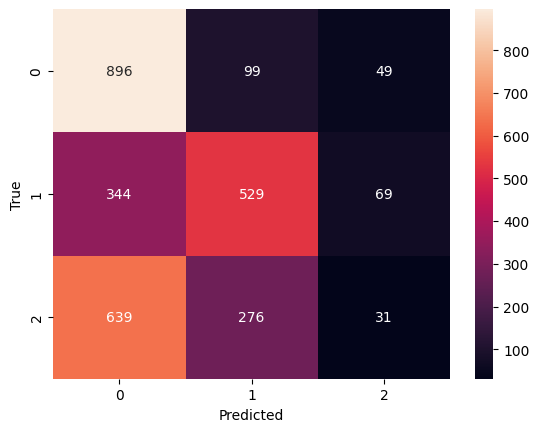

In [528]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, yhat)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

TODO: We are predicing the value being low an unportional amount of times.

## SciKit-Learn Comparison

* [1.5 points] Compare the performance of your "best" logistic regression optimization procedure to the procedure used in scikit-learn. Visualize the performance differences in terms of training time and classification performance. Discuss the results. 


In [533]:
# SciKit Learn
from sklearn.linear_model import LogisticRegression

# Create an instance of the model
lr = LogisticRegression(max_iter=1500)

# Train the model
lr.fit(X, y)

# Predict the test set
yhat = lr.predict(X_test)

# Print the accuracy
print('Accuracy: ', accuracy_score(y_test,yhat))


Accuracy:  0.630968622100955


c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


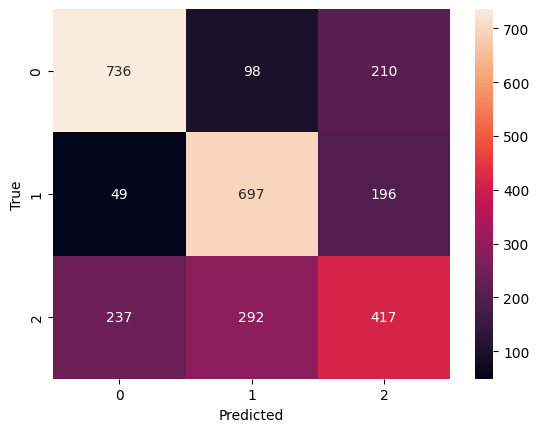

In [530]:
# Confusion Matrix
cm = confusion_matrix(y_test, yhat)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


TODO: Improve this description?

This confusion matrix is interesting because it shows that the model actually does a relatively good job predicitng the low and medium priced housing but does a poor job predicting the high priced housing. This could be due to biasing factors in the data, such as the fact that people are pricing their homes too high. It could also be due to features that we aren't able to capture in the data, such as any value added by the location of the house. It's also interesting to note that the confusion between low and medium priced housing is relatively low, which is somewhat surprising since we would have expected the model to have a harder time distinguishing between classes that are closer together.

# Deployment 
TODO: Which implementation of logistic regression would you advise be used in a deployed machine learning model, your implementation or scikit-learn (or other third party implementation)? Why?


# Exceptional Work (1 points total)
* TODO: Required for 7000 level students: Implement an optimization technique for logistic regression using mean square error as your objective function (instead of maximum likelihood). Derive the gradient updates for the Hessian and use Newton's method to update the values of "w". Then answer, which process do you prefer: maximum likelihood OR minimum mean-squared error? 